# COW PATCH DETECTION

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

## PREPARING IMAGES AND LABELS

In [2]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the path to the folder containing the train images
train_data_path = "/kaggle/input/open-cow-2020/10m32xl88x2b61zlkkgz3fml17/identification/images/train/"

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a fixed size
    transforms.ToTensor(),           # Convert the images to PyTorch tensors
    transforms.Normalize(mean=[0.15, 0.15, 0.15], std=[1, 1, 1])  # Normalize the images
])

# Load the dataset using ImageFolder
dataset = ImageFolder(root=train_data_path, transform=transform)

# Define the dataloader to load the data in batches
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Get the number of classes
num_classes = len(dataset.classes)

# Print the number of classes
print("Number of classes:", num_classes)

# Print the size of the dataset
print("Size of the dataset:", len(dataset))

# Iterate over a few batches to see the images and labels
for images, labels in dataloader:
    print("Batch size:", images.size(0))
    print("Labels:", labels)
    # You can access images and labels for each batch here and use them for training
    break  # Break after printing the first batch


Number of classes: 46
Size of the dataset: 4240
Batch size: 32
Labels: tensor([40, 42, 44, 11, 26, 23, 33,  7,  2,  4, 19, 43, 25,  4,  7, 12, 11,  3,
         3, 15,  3, 39, 27,  1,  2, 40, 11,  4, 13,  4,  3, 25])


## CLASS DISTRIBUTION

In [3]:
di = {}
for folder in tqdm(os.listdir(train_data_path)):
    if "html" not in folder:
        di[folder] = len(os.listdir(train_data_path + folder))

100%|██████████| 48/48 [00:00<00:00, 1561.86it/s]


<Axes: >

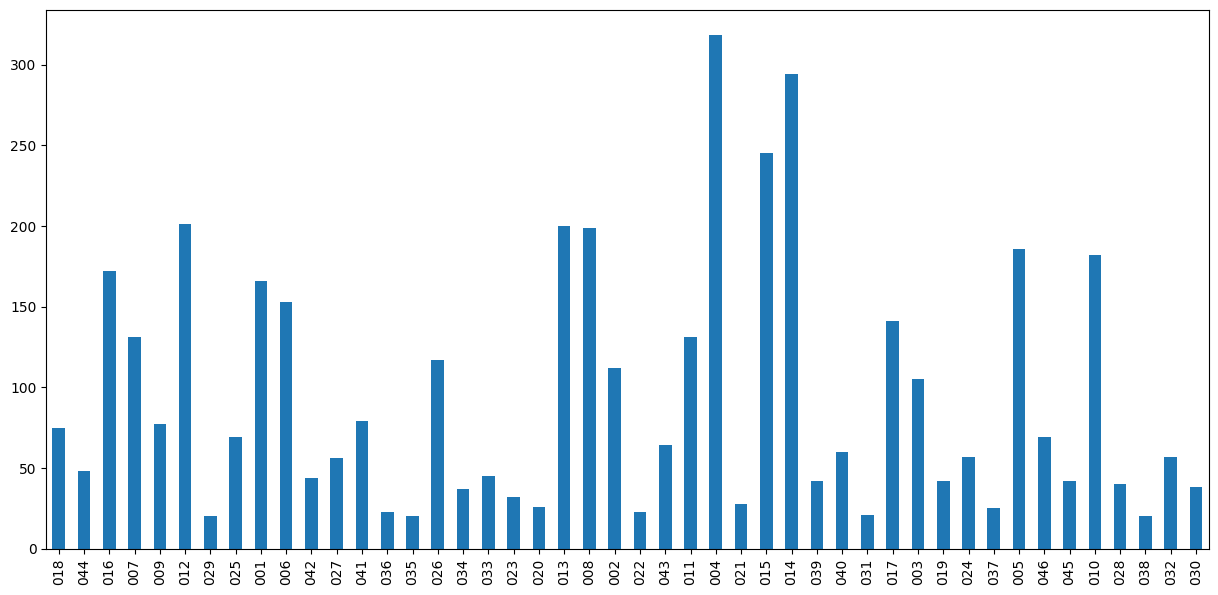

In [4]:
plt.figure(figsize = (15, 7))
pd.DataFrame(di, index = [0]).T[0].plot(kind = "bar")

In [5]:
len(dataloader) * batch_size # No of Images

4256

## VISUALIZING SAMPELS

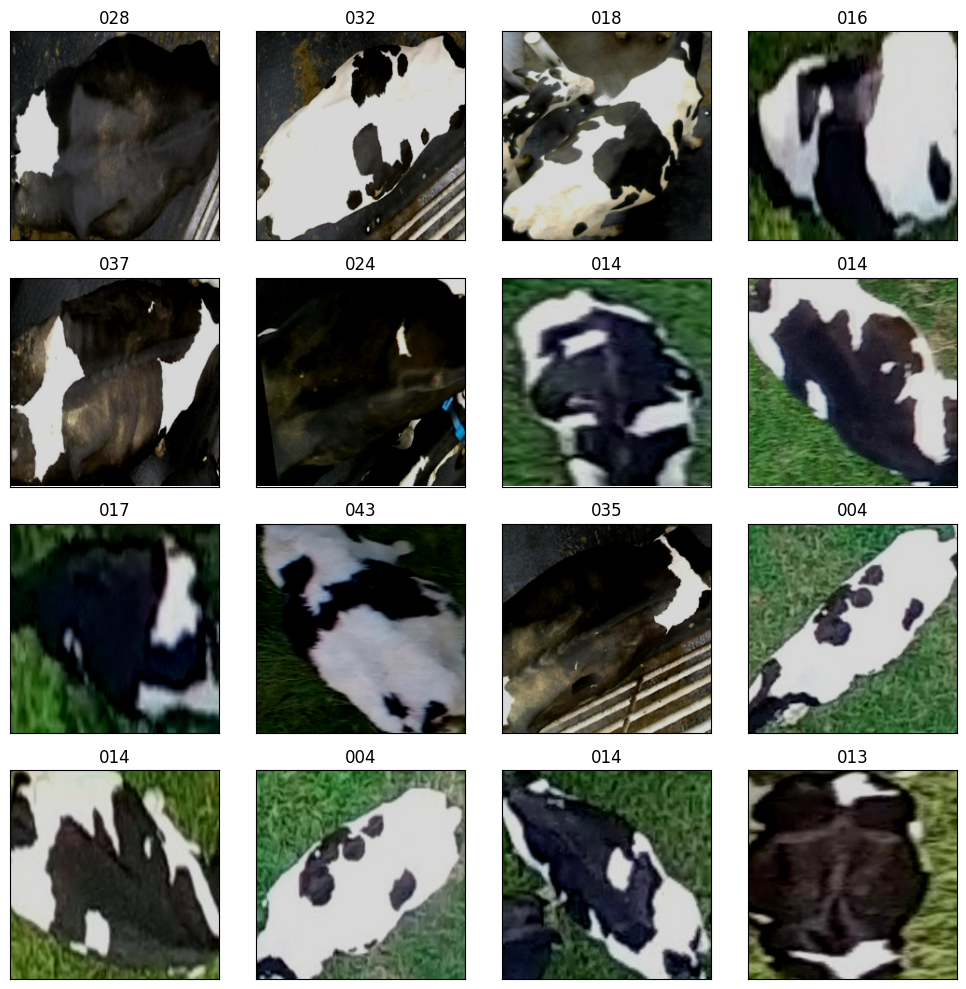

In [6]:
import matplotlib.pyplot as plt

# Function to display a batch of images in a 4x4 grid
def show_images(images, labels, classes):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        # Display image
        ax.imshow(images[i].permute(1, 2, 0))  # permute to (H, W, C) for matplotlib
        ax.set_xticks([])
        ax.set_yticks([])
        # Display label
        class_idx = labels[i].item()
        ax.set_title(classes[class_idx])
    plt.tight_layout()
    plt.show()

# Get a batch of images and labels from the dataloader
images, labels = next(iter(dataloader))

# Define the class labels
classes = dataset.classes

# Show the images and labels in a 4x4 subplot
show_images(images, labels, classes)

# Vit


In [9]:
import torch
import torch.nn as nn
from transformers import ViTModel, ViTConfig

class ViTForFineTuning(nn.Module):
    def __init__(self, num_classes):
        super(ViTForFineTuning, self).__init__()
        config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224', config=config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)

    def forward(self, x):
        # Forward pass through the DeiT model
        output = self.vit(x)
        # Only consider the output of the [CLS] token (first token)
        cls_output = output.last_hidden_state[:, 0, :]
        # Forward pass through the classifier
        logits = self.classifier(cls_output)
        return logits

# Instantiate the model
num_classes = 46  # Number of classes in your dataset
vit = ViTForFineTuning(num_classes)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)

# Print the model architecture
vit

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForFineTuning(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_f

## TRAINING

In [12]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = Adam(vit.parameters(), lr=1e-4)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize lists to store metrics
losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    vit.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
    
    epoch_loss = running_loss / len(dataset)
    epoch_accuracy = running_corrects.double() / total_samples
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    # Append metrics to lists
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy.item())
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    scheduler.step()

print("Training finished!")

100%|██████████| 133/133 [02:57<00:00,  1.34s/it]


Epoch [1/5], Loss: 0.8138, Accuracy: 0.8271, Precision: 0.8737, Recall: 0.7815, F1-score: 0.8152


100%|██████████| 133/133 [02:34<00:00,  1.16s/it]


Epoch [2/5], Loss: 0.0261, Accuracy: 0.9974, Precision: 0.9979, Recall: 0.9973, F1-score: 0.9975


100%|██████████| 133/133 [02:34<00:00,  1.16s/it]


Epoch [3/5], Loss: 0.0163, Accuracy: 0.9974, Precision: 0.9986, Recall: 0.9986, F1-score: 0.9986


100%|██████████| 133/133 [02:35<00:00,  1.17s/it]


Epoch [4/5], Loss: 0.0062, Accuracy: 0.9993, Precision: 0.9997, Recall: 0.9997, F1-score: 0.9997


100%|██████████| 133/133 [02:33<00:00,  1.16s/it]

Epoch [5/5], Loss: 0.0018, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
Training finished!


## MODEL EVALUATION

In [13]:
# Create DataFrame
training_logs = pd.DataFrame({
    'Epoch': range(1, num_epochs+1),
    'Loss': losses,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-score': f1_scores
})
# training_logs.set_index("Epoch", inplace = True)
# training_logs.to_csv("training_logs.csv")
training_logs

,Epoch,Loss,Accuracy,Precision,Recall,F1-score
0,1,0.813793,0.827123,0.873674,0.781513,0.815236
1,2,0.026131,0.997406,0.997866,0.997273,0.997547
2,3,0.016330,0.997406,0.998601,0.998610,0.998605
3,4,0.006153,0.999292,0.999654,0.999661,0.999657
4,5,0.001814,1.000000,1.000000,1.000000,1.000000


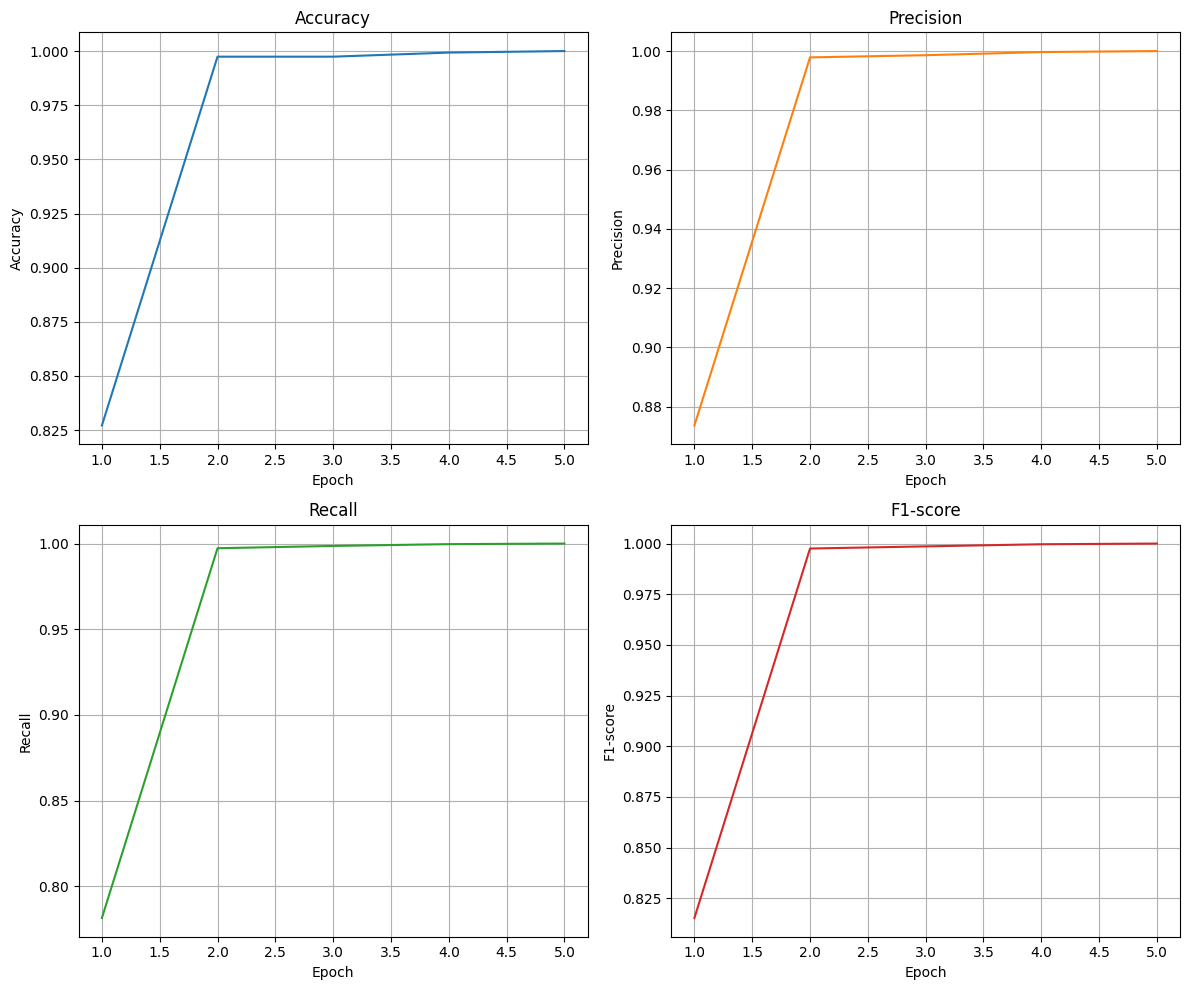

In [14]:
# Plot subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(training_logs['Epoch'], training_logs['Accuracy'], label='Accuracy', color='tab:blue')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].grid(True)

axs[0, 1].plot(training_logs['Epoch'], training_logs['Precision'], label='Precision', color='tab:orange')
axs[0, 1].set_title('Precision')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].grid(True)

axs[1, 0].plot(training_logs['Epoch'], training_logs['Recall'], label='Recall', color='tab:green')
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].grid(True)

axs[1, 1].plot(training_logs['Epoch'], training_logs['F1-score'], label='F1-score', color='tab:red')
axs[1, 1].set_title('F1-score')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('F1-score')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [15]:
torch.save(vit.state_dict(), "vit_model.pth")

# THANKYOU